In [ ]:
import pyvista as pv
pv.set_jupyter_backend('html')

import pyvista as pv
import time
import os

import matplotlib.pyplot as p
import numpy as np
import xarray as xr
from IPython.display import Image

import cedalion
import cedalion.dataclasses as cdc
import cedalion_parcellation.datasets
import cedalion.sigproc.quality as quality
import cedalion.geometry.registration
import cedalion.geometry.segmentation
import cedalion.imagereco.forward_model as fw
import cedalion.imagereco.tissue_properties
import cedalion.io
import cedalion_parcellation.plots
import cedalion.plots
import cedalion.vis.plot_sensitivity_matrix
import cedalion_parcellation.imagereco.forward_model as fw
from cedalion.imagereco.solver import pseudo_inverse_stacked
import pickle
from cedalion.io import read_snirf
import cedalion.sigproc.motion_correct as motion_correct
from cedalion.sigproc.quality import repair_amp

# import the fine (replace)
subject = "nc726"     
exp_path = f"/app/jasmin/data/raw/original/"
filename = f"{exp_path}{subject}/ninja/{subject}.snirf"
    
# load the snirf file
rec = read_snirf(filename)[0]
rec['amp'] = repair_amp(rec["amp"]) #pre-process

# compute TDDR
rec["od"], baseline = cedalion.nirs.int2od(rec["amp"], return_baseline=True)

# compute motion correct
rec["od_tddr"] = motion_correct.tddr(rec["od"])
rec["od_wavelet"] = motion_correct.motion_correct_wavelet(rec["od_tddr"])

# final amplitude of the data
rec["amp_final"] = cedalion.nirs.od2int(rec["od_wavelet"], baseline)


In [13]:
import cedalion.dataclasses.geometry as geom

print("Loaded from:", geom.__file__)
prop = geom.TrimeshSurface.vertices
print("Has setter?", prop.fset is not None)
print("Setter points to:", prop.fset)


Loaded from: /home/jash/cedalion/src/cedalion/dataclasses/geometry.py
Has setter? False
Setter points to: None


In [9]:


#head-model
SEG_DATADIR, mask_files, landmarks_file = cedalion_parcellation.datasets.get_icbm152_segmentation()
PARCEL_DIR = cedalion_parcellation.datasets.get_icbm152_parcel_file()

# the two surface head model. 
head = fw.TwoSurfaceHeadModel.from_surfaces(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    brain_surface_file= os.path.join(SEG_DATADIR, "mask_brain.obj"),
    scalp_surface_file= os.path.join(SEG_DATADIR, "mask_scalp.obj"),
    landmarks_ras_file=landmarks_file,
    parcel_file=PARCEL_DIR,
    brain_face_count=None,
    scalp_face_count=None
)

T = np.array([[-9.57882733e-01, -7.20806358e-03,  6.20193531e-03,
         2.21208571e+02],
       [-2.02271710e-02,  6.03819925e-02,  9.94046165e-01,
        -2.03010603e+01],
       [-8.79481533e-03, -1.02761992e+00,  6.59199998e-02,
         2.87749135e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
ninja_aligned = rec.geo3d.points.apply_transform(T)
#cedalion.plots.plot_montage3D(rec["amp"], ninja_aligned)

# # optode registration
geo3d_snapped_ijk = head.align_and_snap_to_scalp(ninja_aligned)

plt = pv.Plotter()
cedalion_parcellation.plots.plot_surface(plt, head.brain, color="w")
cedalion_parcellation.plots.plot_surface(plt, head.scalp, opacity=.1)
cedalion_parcellation.plots.plot_labeled_points(plt, geo3d_snapped_ijk)
plt.show()


AttributeError: property 'vertices' of 'TrimeshSurface' object has no setter

In [3]:
# simulate light propergation in tissue
fwm = cedalion_parcellation.imagereco.forward_model.ForwardModel(head, geo3d_snapped_ijk, rec._measurement_lists["amp"])
FORWARD_MODEL = "MCX"

In [ ]:
# # run the simulation and save it (only once)
# fluence_all, fluence_at_optodes = fwm.compute_fluence_mcx()

# #-save it for later/re-use
# import pickle
# with open('/home/theek/ibs_adl/dynamic_dmn/fluence_at_optodes_dyd.pickle', 'wb') as handle:
#    pickle.dump(fluence_at_optodes, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/home/theek/ibs_adl/dynamic_dmn/fluence_all_dyd.pickle', 'wb') as handle:
#     pickle.dump(fluence_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#load it
with open('/home/jash/data/derived/fluence_at_optodes.pickle', 'rb') as handle:
    fluence_at_optodes = pickle.load(handle)
with open('/home/jash/data/derived/fluence_all.pickle', 'rb') as handle:
    fluence_all = pickle.load(handle)

geo3d_plot = geo3d_snapped_ijk[geo3d_snapped_ijk.type != cdc.PointType.LANDMARK]

# you can also save Adot
Adot = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)

#plot sensitivity matrix
plotter = cedalion.vis.plot_sensitivity_matrix.Main(
    sensitivity=Adot,
    brain_surface=head.brain,
    head_surface=head.scalp,
    labeled_points=geo3d_plot,
)
plotter.plot(high_th=0, low_th=-3)
plotter.plt.show()

Adot_stacked = fwm.compute_stacked_sensitivity(Adot)

# invert the sensitivity matrix 
B = pseudo_inverse_stacked(Adot_stacked, alpha = 0.01, alpha_spatial = 0.001)
nvertices = B.shape[0]//2
B = B.assign_coords({"chromo" : ("flat_vertex", ["HbO"]*nvertices  + ["HbR"]* nvertices)})
B = B.set_xindex("chromo")
B = B.assign_coords({"parcel" : ("flat_vertex", np.concatenate((Adot.coords['parcel'].values, Adot.coords['parcel'].values)))})

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [5]:
# channel x parcel map (sensitivity)
Adot_prime = Adot.groupby('parcel').mean()
Adot_prime = Adot_prime.sel(wavelength = 760)


In [24]:
parcels = sorted(Adot_prime.parcel.values.tolist())
parcels = [p for p in parcels if  'LH' in p]

print(parcels)

['Background+FreeSurfer_Defined_Medial_Wall_LH', 'ContA_Cingm_1_LH', 'ContA_IPS_1_LH', 'ContA_IPS_2_LH', 'ContA_IPS_3_LH', 'ContA_IPS_4_LH', 'ContA_IPS_5_LH', 'ContA_IPS_6_LH', 'ContA_PFCd_1_LH', 'ContA_PFCd_2_LH', 'ContA_PFCl_1_LH', 'ContA_PFCl_2_LH', 'ContA_PFCl_3_LH', 'ContA_PFCl_4_LH', 'ContA_PFCl_5_LH', 'ContA_PFCl_6_LH', 'ContA_PFClv_1_LH', 'ContA_PFClv_2_LH', 'ContA_Temp_1_LH', 'ContA_Temp_2_LH', 'ContB_IPL_1_LH', 'ContB_IPL_2_LH', 'ContB_IPL_3_LH', 'ContB_IPL_4_LH', 'ContB_IPL_5_LH', 'ContB_PFCd_1_LH', 'ContB_PFCl_1_LH', 'ContB_PFCl_2_LH', 'ContB_PFClv_1_LH', 'ContB_PFClv_2_LH', 'ContB_PFClv_3_LH', 'ContB_PFCmp_1_LH', 'ContB_Temp_1_LH', 'ContB_Temp_2_LH', 'ContC_Cingp_1_LH', 'ContC_Cingp_2_LH', 'ContC_pCun_1_LH', 'ContC_pCun_2_LH', 'ContC_pCun_3_LH', 'ContC_pCun_4_LH', 'ContC_pCun_5_LH', 'ContC_pCun_6_LH', 'DefaultA_IPL_1_LH', 'DefaultA_IPL_2_LH', 'DefaultA_IPL_3_LH', 'DefaultA_IPL_4_LH', 'DefaultA_PFCd_1_LH', 'DefaultA_PFCd_2_LH', 'DefaultA_PFCd_3_LH', 'DefaultA_PFCm_1_LH', 'D

In [ ]:
# select a set of parcels
# selected_parcels = ["SomMotA_4_LH", "SomMotA_9_LH", "SomMotA_5_LH", "SomMotA_6_LH", 
#                     "SomMotA_7_LH", "SomMotA_8_LH"]

selected_parcels = ['DefaultA_PFCd_1_LH', 'DefaultA_PFCd_2_LH', 'DefaultA_PFCd_3_LH']

In [46]:
# to visualize parcels 
b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)

# Ensure the fallback array has the correct shape
default_color = np.array([1, 1, 1])  # Shape (3,)
parcels = cedalion_parcellation.io.read_parcellations(PARCEL_DIR)
# Create mask for selected labels

mask = parcels['Label'].isin(selected_parcels).values

# Use np.where while ensuring correct broadcasting
selected_colors = np.where(mask[:, None], parcels['Color'].to_list(), default_color)

b["parcels"] = selected_colors

plt = pv.Plotter()

plt.add_text('#parcels: {}'.format(len(selected_parcels)), font_size=8)
plt.add_mesh(
    b,
    scalars="parcels",
    rgb=True
)

if "parcel" in head.brain.vertices.coords:
    cog = head.brain.vertices.mean(["label", "parcel"]).values
else:
    cog = head.brain.vertices.mean("label").values
cedalion_parcellation.plots.plot_labeled_points(plt, geo3d_snapped_ijk, show_labels=True)


plt.camera.position = cog + [0,0,400]
plt.camera.focal_point = cog 
plt.camera.up = [0,1,0] 
plt.reset_camera()
plt.show()

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [60]:
# the small region
region = Adot_prime.sel(parcel=selected_parcels)

# find the sensitive channels, use a threshold
channel_sensitive = region.sum(dim='parcel')
sensitive_channels = channel_sensitive.channel[channel_sensitive > 0.05]
print("the number of sensitive channels:", sensitive_channels.shape)
display([s for s in sensitive_channels.values])

the number of sensitive channels: (9,)


['S3D38',
 'S6D40',
 'S7D2',
 'S7D36',
 'S56D38',
 'S56D15',
 'S6D121',
 'S6D124',
 'S7D122']

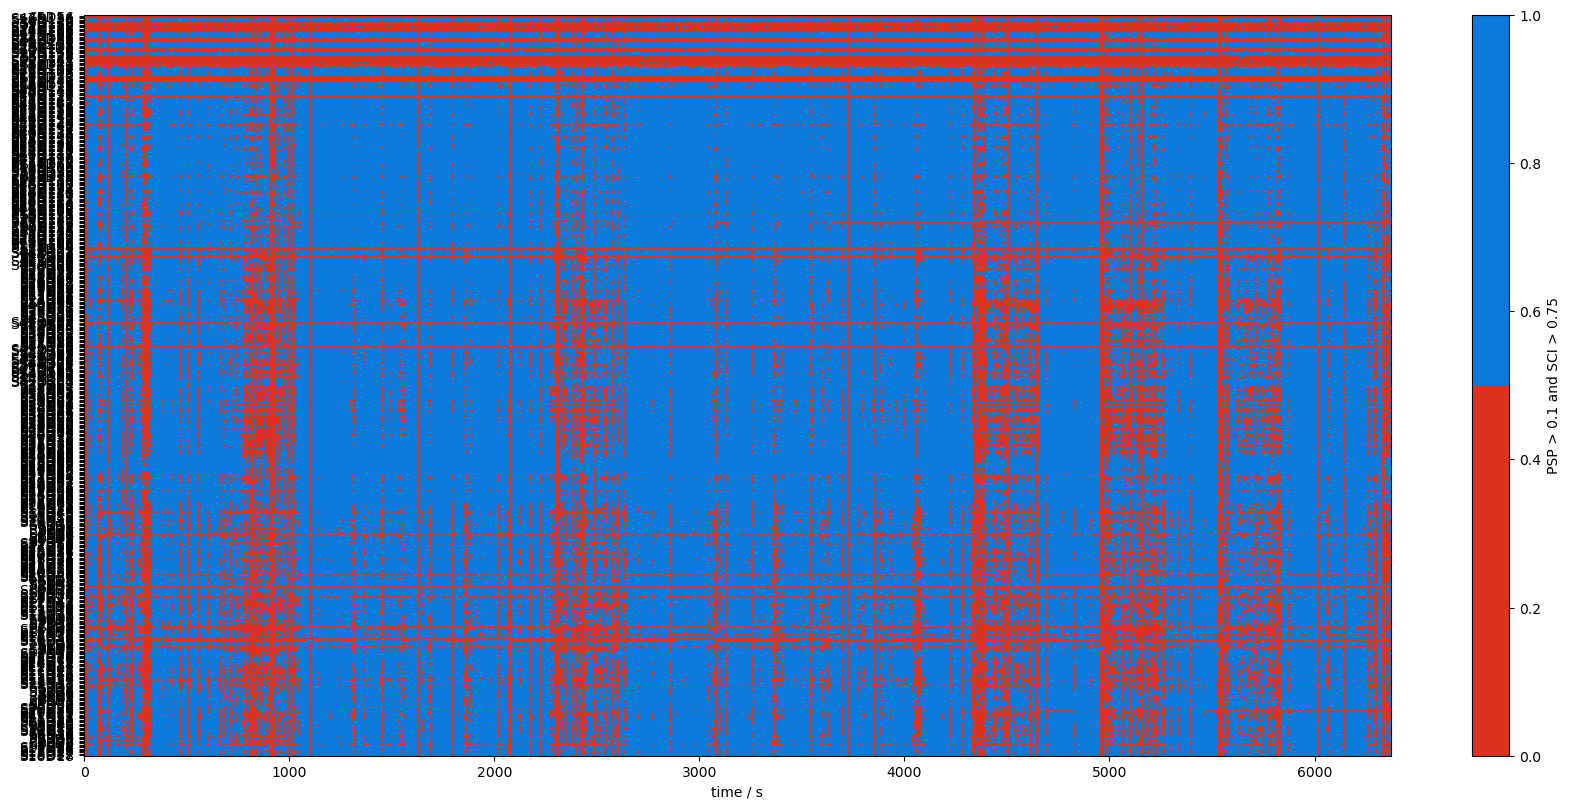

In [9]:
#scipsp
# compute scixpsp
# compute the sci-psp-time maskes
import pickle
import warnings
from cedalion import units
import glob 
from cedalion.sigproc.quality import  gvtd
from cedalion.io import read_snirf
import numpy as np
import cedalion.sigproc.quality as quality
import matplotlib.pyplot as p
# generate time plot
import cedalion.plots as plots
import cedalion.plots as plots
from matplotlib.colors import LinearSegmentedColormap

window_length = 5*units.s
sci_threshold = 0.75
psp_threshold = 0.1

psp, psp_mask = quality.psp(rec["amp_final"], window_length, psp_threshold)
sci, sci_mask = quality.sci(rec["amp_final"], window_length, sci_threshold)
sci_x_psp_mask = sci_mask & psp_mask

perc_time_clean = sci_x_psp_mask.sum(dim="time") / len(sci.time)
# get the cleaned 90% of clean time
cleaned = perc_time_clean > 0.60
chan_droplist = rec['amp_final'].channel[np.logical_not(cleaned)].to_numpy()

# we can plot a heat map to visualize the SCI across all time windows and channels
colors = ["black", "#DC3220", "#5D3A9B", "#0C7BDC"]
nodes = [0.0, 0.75, 0.751, 1.0]
sci_cmap = LinearSegmentedColormap.from_list("sci_cmap", list(zip(nodes,colors)))
sci_binary_cmap = LinearSegmentedColormap.from_list("sci_binary_cmap", list(zip([0,0.5,0.5,1],["#DC3220","#DC3220","#0C7BDC","#0C7BDC"])))

# we can also plot this as a binary heatmap
f,ax = p.subplots(1,1,figsize=(17,8))

m = ax.pcolormesh(sci_x_psp_mask.time, np.arange(len(sci_x_psp_mask.channel)), sci_x_psp_mask, shading="nearest", cmap=sci_binary_cmap)
cb = p.colorbar(m, ax=ax)
p.tight_layout()
ax.yaxis.set_ticks(np.arange(len(sci_x_psp_mask.channel)))
ax.yaxis.set_ticklabels(sci_x_psp_mask.channel.values);
cb.set_label("PSP > 0.1 and SCI > 0.75")
ax.set_xlabel("time / s");

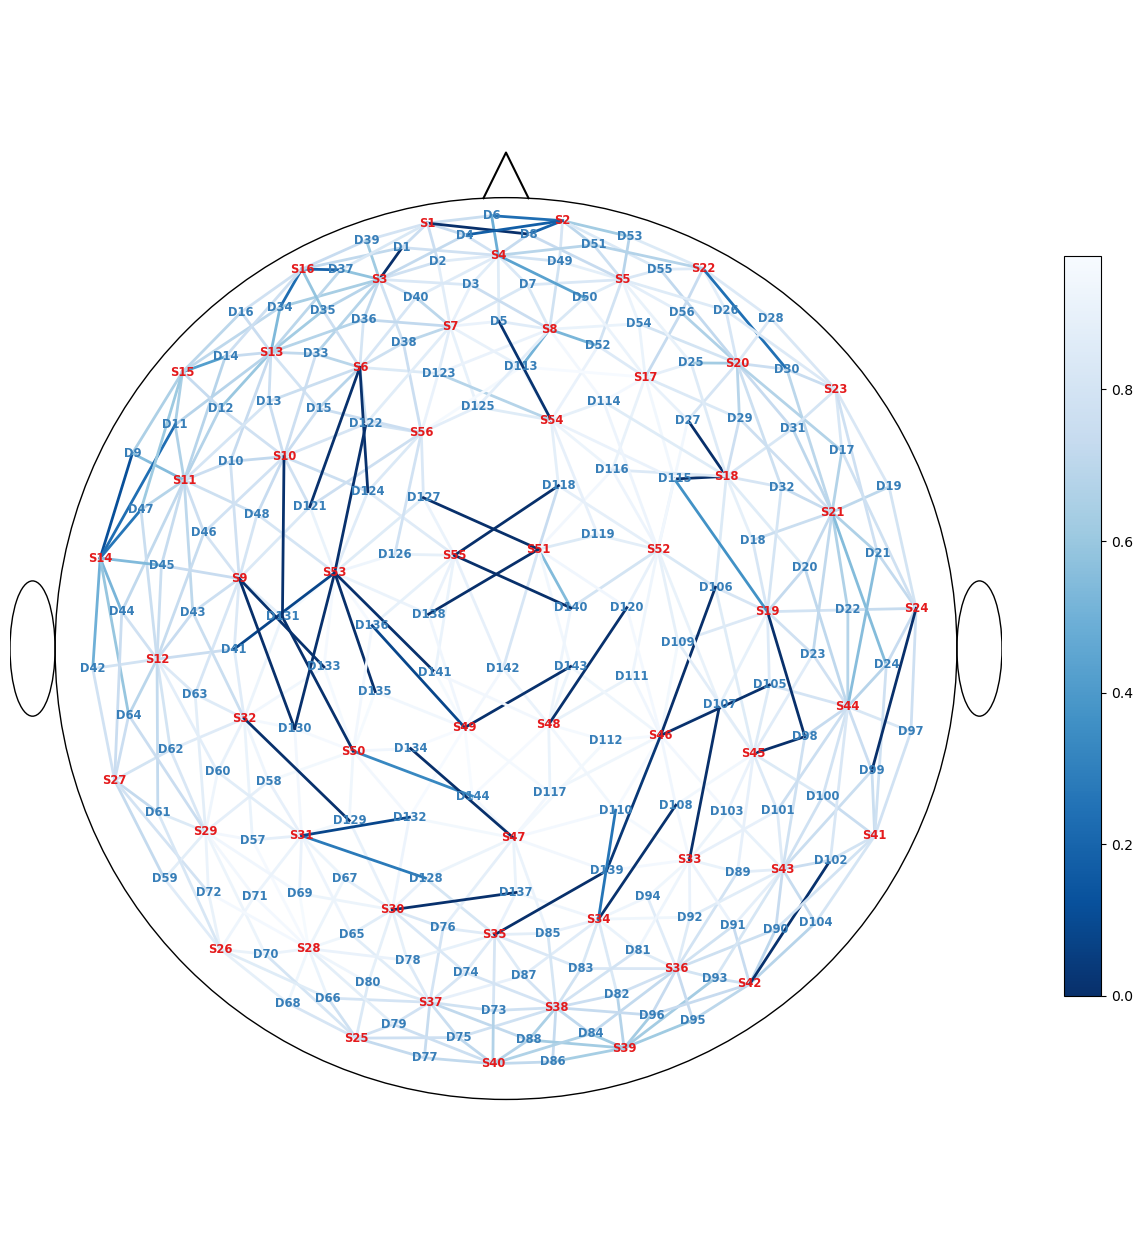

In [10]:
fig, ax = p.subplots(1,1, figsize=(16,16))
perc_time_clean = sci_x_psp_mask.sum(dim="time") / len(sci.time)
cedalion.plots.scalp_plot(rec["amp_final"], rec.geo3d, perc_time_clean, ax, optode_labels=True, cmap='Blues_r')

In [36]:
print([v for v in channel_sensitive.values if v in chan_droplist])

[]


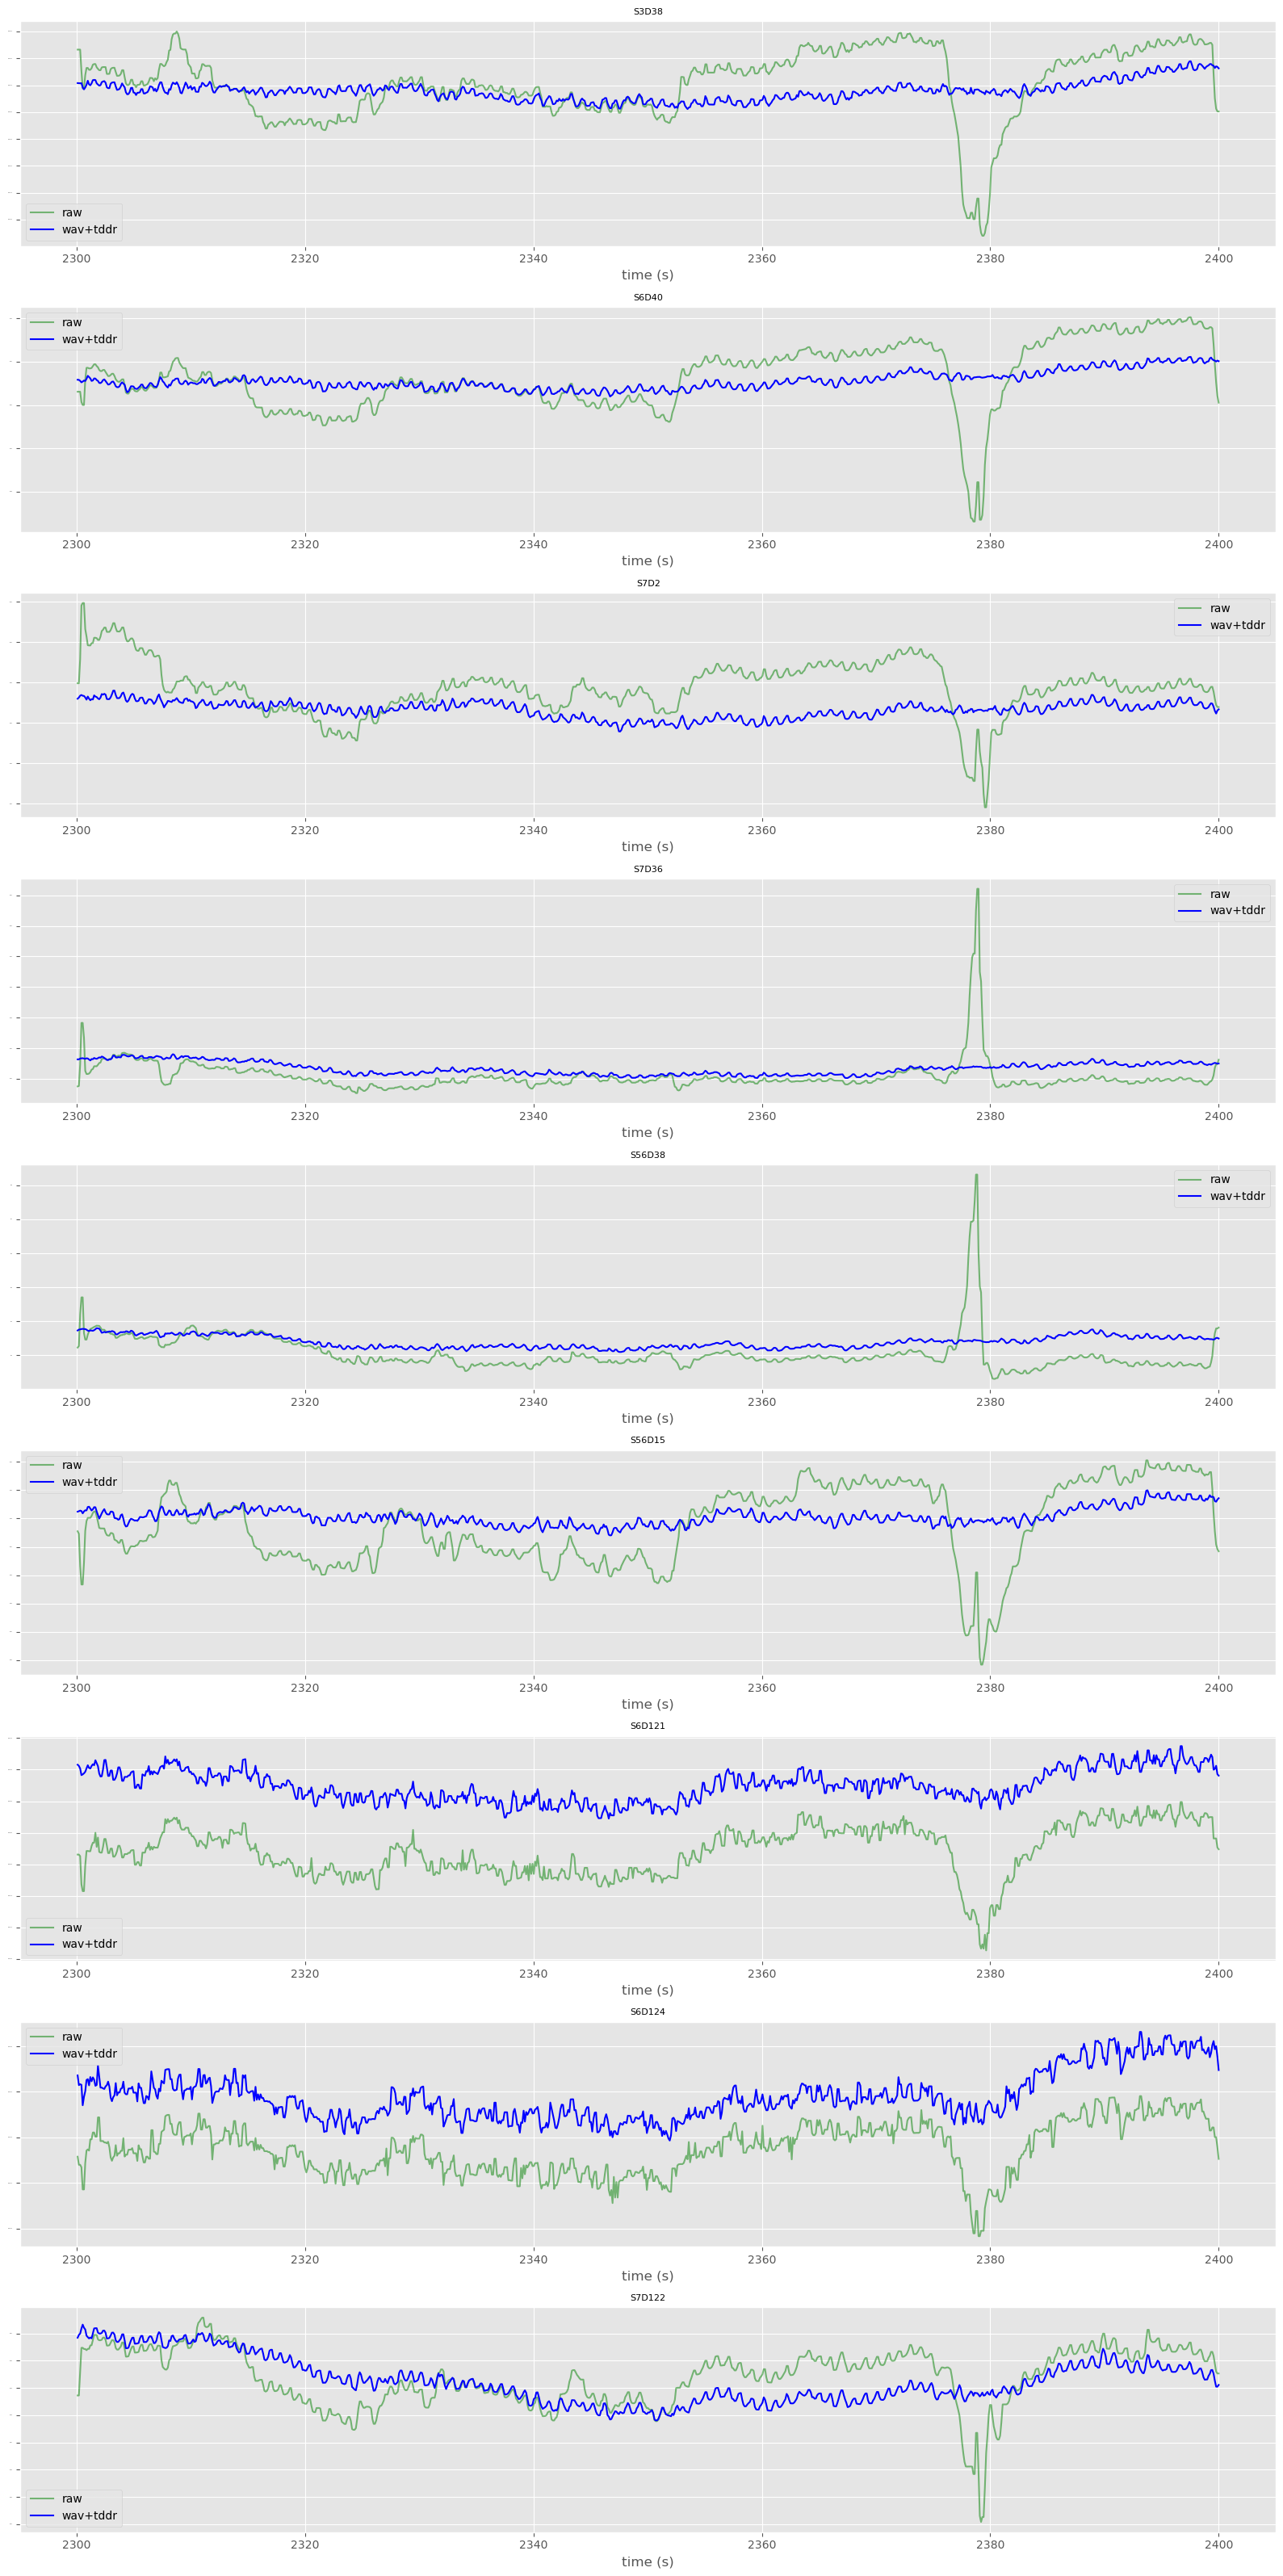

In [61]:
# create time domain plots
st, end = 2300, 2400
raw_data_segment = rec["amp"].sel(time=slice(st, end))
corrected_data_segment = rec["amp_final"].sel(time=slice(st, end))

N = len(sensitive_channels)

p.style.use('ggplot')
_ = p.figure(figsize=(16, 32))
for i, channel in enumerate(sensitive_channels.values):
    p.subplot(N,1,i+1)
    p.plot(raw_data_segment.time, raw_data_segment.sel(channel=channel)[0], label='raw', c='g', alpha=0.5)
    p.plot(corrected_data_segment.time, corrected_data_segment.sel(channel=channel)[0], label='wav+tddr', c='b')
    p.xlabel('time (s)')
    p.yticks(fontsize=1)
    p.title(channel, fontsize=8)
    p.legend()
p.tight_layout()


In [ ]:
np.float_ = np.float64
display(raw_data_segment)

In [ ]:
import time
start_whole = time.time()
# transform the real signal
reshape = rec["od_wavelet"].transpose('time', "wavelength", "channel")
od_stacked = reshape.stack({"flat_channel" : ["wavelength", "channel"]})

start_matmul = time.time()
dC_t = B @ od_stacked
end_matmul = time.time() - start_matmul
print("Time taken for matrix multiplication:", end_matmul)

# extract Hbo/Hbr signals
brain_dC = dC_t[list((Adot.is_brain == True).values)*2, :]

hbr = brain_dC.sel(chromo='HbR').pint.dequantify() / 1e-6
hbr = hbr.groupby('parcel').mean()
hbo = brain_dC.sel(chromo='HbO').pint.dequantify() / 1e-6
hbo = hbo.groupby('parcel').mean()

signal = xr.concat([hbo, hbr], dim='chromo')
end_whole = time.time() - start_whole
print("Time taken for the whole process: ", end_whole)

In [ ]:
# save for later
with open('/home/theek/ibs_adl/dynamic_dmn/signal.pickle', 'wb') as handle:
    pickle.dump(signal, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# filtered = signal.rename({"parcel": "channel"})
# filtered = filtered.assign_coords(samples=("time", range(len(filtered["time"]))))
# filtered.time.attrs["units"] = "seconds"
# filtered = filtered.cd.freq_filter(fmin=0.01, fmax=0.5, butter_order=4)
# signal_filterd = filtered.rename({"channel": "parcel"}).transpose('chromo', "parcel", "time")

In [ ]:
# with open('/home/theek/ibs_adl/dynamic_dmn/signal_filterd.pickle', 'wb') as handle:
#     pickle.dump(signal_filterd, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# load the files
with open('/home/theek/ibs_adl/dynamic_dmn/signal.pickle', 'rb') as handle:
    signal = pickle.load(handle)
with open('/home/theek/ibs_adl/dynamic_dmn/signal_filterd.pickle', 'rb') as handle:
    signal_filterd = pickle.load(handle)

display(signal_filterd)

<xarray.DataArray (chromo: 2, parcel: 602, time: 57256)> Size: 551MB
array([[[-6.94645337e-08, -3.35049962e-07, -6.27567626e-07, ...,
          8.79984297e-08,  7.46268597e-08,  6.07032880e-08],
        [-1.49237987e-07, -5.17250674e-07, -9.23293959e-07, ...,
          1.34643771e-07,  1.16743324e-07,  9.84559732e-08],
        [ 1.08351692e-06,  5.23324193e-07, -3.78209932e-08, ...,
         -1.60914444e-06, -1.65872232e-06, -1.73255987e-06],
        ...,
        [-1.00615466e-07, -1.31245125e-06, -2.65503209e-06, ...,
          8.53154484e-07,  7.67250107e-07,  6.81193298e-07],
        [-6.71986102e-07, -2.32753780e-06, -4.14773132e-06, ...,
          5.04112774e-07,  4.32355838e-07,  3.58663506e-07],
        [-1.37581539e-05, -4.15453663e-05, -7.29895665e-05, ...,
          5.38481171e-05,  4.68037391e-05,  3.95899243e-05]],

       [[-1.43881043e-07, -6.14188329e-07, -1.12459881e-06, ...,
         -2.93863341e-07, -2.54348153e-07, -2.14154032e-07],
        [-2.05365786e-07, -7.60453631e-07, -1.36642999e-06, ...,
         -1.87074304e-07, -1.65163838e-07, -1.42868170e-07],
        [-9.48660585e-10, -1.27482047e-06, -2.58200704e-06, ...,
         -7.41094658e-06, -6.79420869e-06, -6.17868540e-06],
        ...,
        [-7.83939130e-07, -3.28953490e-06, -5.99705979e-06, ...,
         -2.01414564e-06, -1.77551486e-06, -1.53229080e-06],
        [-1.10616386e-06, -3.44957291e-06, -6.00546213e-06, ...,
         -5.08401421e-07, -4.42130410e-07, -3.74088239e-07],
        [-2.30560934e-05, -6.96904984e-05, -1.20865627e-04, ...,
          7.27956025e-06,  6.27231351e-06,  5.22750241e-06]]])
Coordinates:
  * time     (time) float64 458kB 0.0 0.1112 0.2225 ... 6.37e+03 6.37e+03
    samples  (time) int64 458kB 0 1 2 3 4 5 ... 57251 57252 57253 57254 57255
  * parcel   (parcel) object 5kB 'Background+FreeSurfer_Defined_Medial_Wall_L...
Dimensions without coordinates: chromo

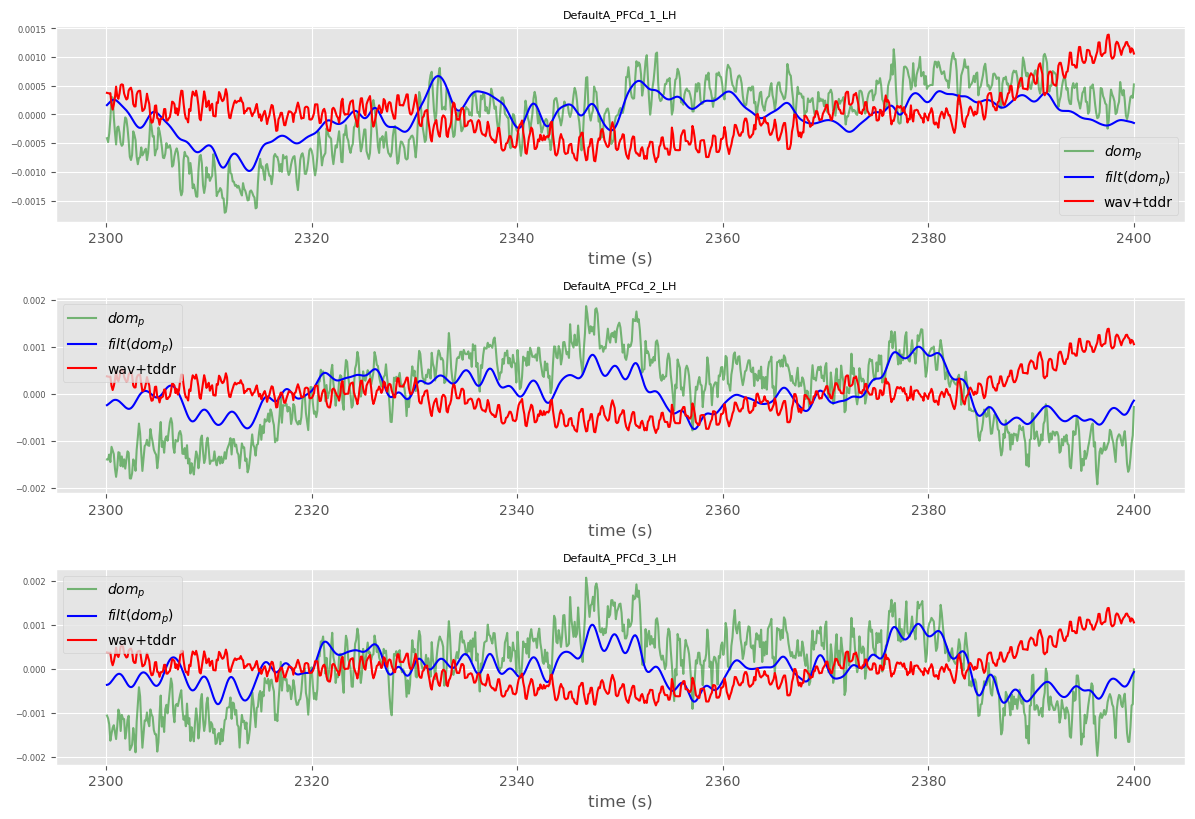

In [62]:
# create time domain plots
raw_parcel_segment = signal.sel(time=slice(st, end))
filtered_parcel_segment = signal_filterd.sel(time=slice(st, end))

p.style.use('ggplot')
_ = p.figure(figsize=(12, 16))
for i, parcel in enumerate(selected_parcels):
    p.subplot(6,1,i+1)
    p.plot(raw_parcel_segment.time, raw_parcel_segment.sel(parcel=parcel)[0] - raw_parcel_segment.sel(parcel=parcel)[0].mean(), label='$dom_p$', c='g', alpha=0.5)
    p.plot(filtered_parcel_segment.time, filtered_parcel_segment.sel(parcel=parcel)[0] - filtered_parcel_segment.sel(parcel=parcel)[0].mean(), label='$filt(dom_p)$', c='b')
    p.plot(corrected_data_segment.time, 5*(corrected_data_segment.sel(channel='S3D38', wavelength=760.0) - corrected_data_segment.sel(channel='S3D38', wavelength=760.0).mean()), label='wav+tddr', c='r')

    p.xlabel('time (s)')
    p.yticks(fontsize=6)
    p.title(parcel, fontsize=8)
    p.legend()
p.tight_layout()